# Stress implementation

In [1]:
import os
import tifffile as tf

import matplotlib.pyplot as plt
import napari

import pandas as pd
import numpy as np

from stress import stress, utils, tracing

%matplotlib notebook

Load data

### Config

In [2]:
fluorescence = 'interior'  # type of fluorescence
n_samples = 2**8  # number of points on initial estimate
trace_fit_method = 'quick_edge'

### Processing

In [3]:
root = r'D:\Documents\Promotion\Projects\2021_STRESS_translation'
f_image = os.path.join(root, 'data', 'ExampleTifSequence-InteriorLabel-vsx_2.076um-vsz_3.998um-TimeInterval_3.00min-21timesteps.tif')    

series = tf.imread(f_image)

Pick one timepoint and visualize

<IPython.core.display.Javascript object>


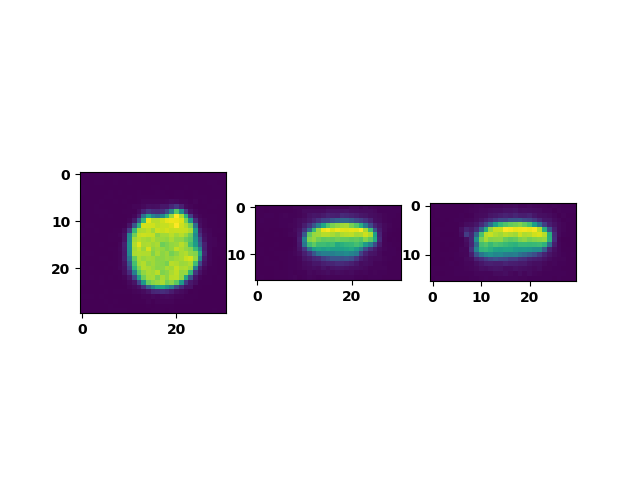

In [4]:
image = series[0]

fig, axes = plt.subplots(ncols=3)
axes[0].imshow(image[image.shape[0]//2])
axes[1].imshow(image[:, image.shape[1]//2, :])
axes[2].imshow(image[:, :, image.shape[2]//2])

### Preprocessing
Do some preprocessing:
- Resampling

<IPython.core.display.Javascript object>


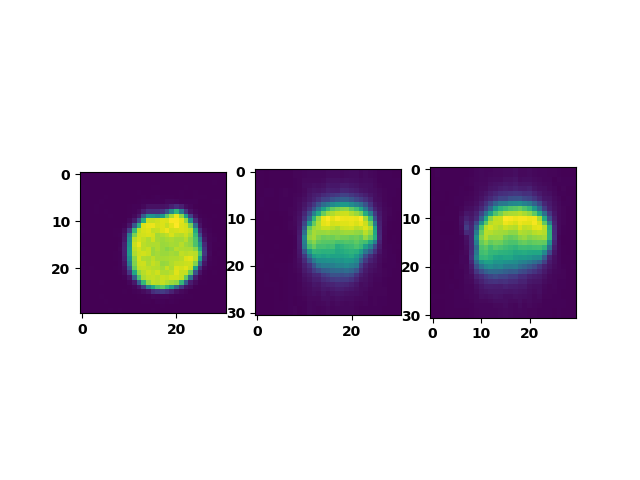

In [5]:
image = stress.preprocessing(image, vsx=2.076, vsy=2.076, vsz=3.998)

fig, axes = plt.subplots(ncols=3)
axes[0].imshow(image[15])
axes[1].imshow(image[:, 15, :])
axes[2].imshow(image[:, :, 15])

###  Initial ellipse fit
To get an initial estimate on the shape and surface of the oil drop, fit an ellipse to the dropplet:

In [13]:
_points = stress.fit_ellipse(image, fluorescence=fluorescence, n_samples=n_samples)

To keep track of the data, create a pandas dataframe for our data and store the detected points in the dataframe:

In [14]:
_points = np.asarray(_points).transpose()  # convert to 3xN array
points = pd.DataFrame(columns=['Z', 'Y', 'X'])
points['Z'] = _points[0, :]
points['Y'] = _points[1]
points['X'] = _points[2]
center = np.asarray([points.Z.mean(), points.Y.mean(), points.X.mean()])

Visualize in napari

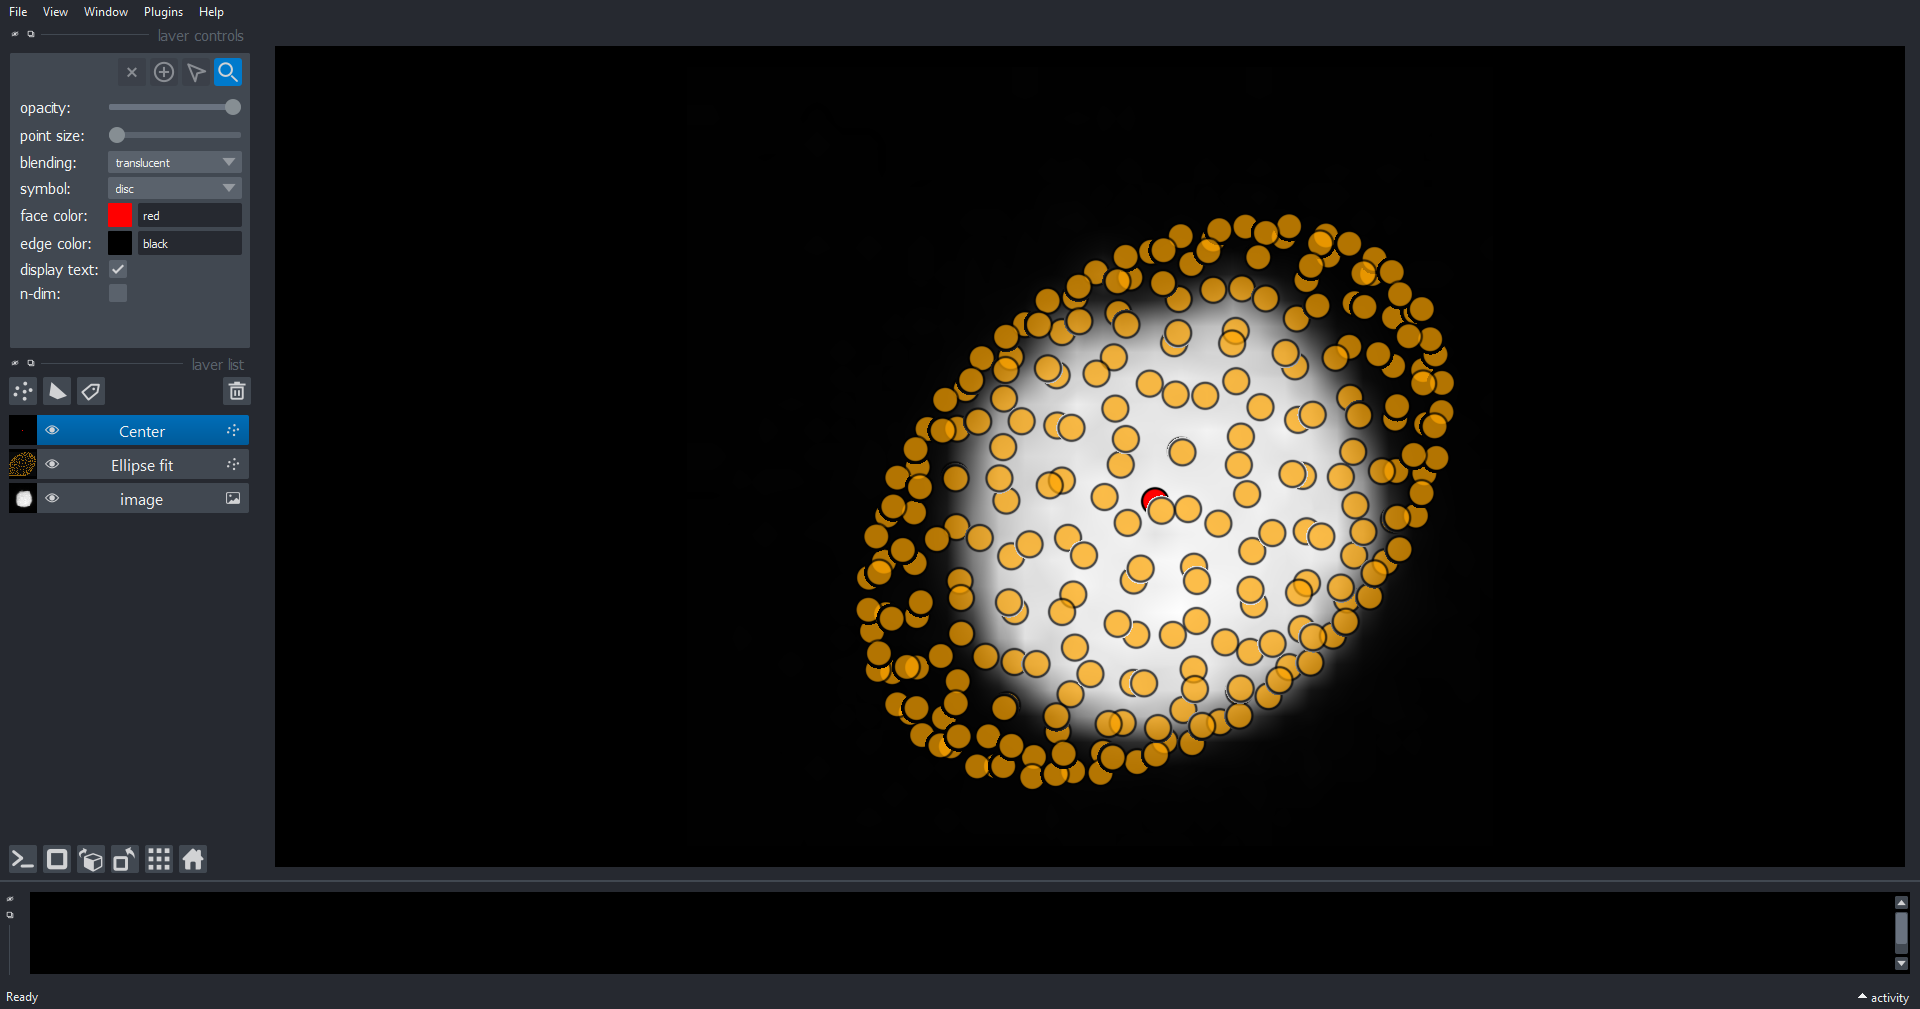

In [15]:
viewer = napari.Viewer(ndisplay=3)
viewer.add_image(image, colormap='gray')
ellipse_layer = viewer.add_points(utils.df2ZYX(points), size=1, face_color ='orange', edge_width=0.1, opacity=0.7, name='Ellipse fit')
viewer.add_points(center, size=1, face_color ='red', edge_width=0.1, opacity=1.0, name='Center')
napari.utils.nbscreenshot(viewer, canvas_only=False)

### Ray-tracing
Shoot rays from center towards all currently known surface points. Image intensity is measured along the way.
If fluorescence = 'interior', the surface is considered to be the location where intensity drops to 0.5 x maxIntensity.
If fluorescence = 'edge', the surface is considered to be the location of maximal intesity along the ray.

In [16]:
new_points, errors, fitparams = tracing.get_traces(image, start_pts=center, target_pts=utils.df2ZYX(points),
                                                    detection=trace_fit_method, fluorescence=fluorescence)
points['Z'] = new_points[:, 0]
points['Y'] = new_points[:, 1]
points['X'] = new_points[:, 2]
points['errors'] = errors
points['fitparams'] = fitparams

Shooting rays: 100%|████████████████████████████████████████████████████████████████| 256/256 [00:01<00:00, 130.43it/s]


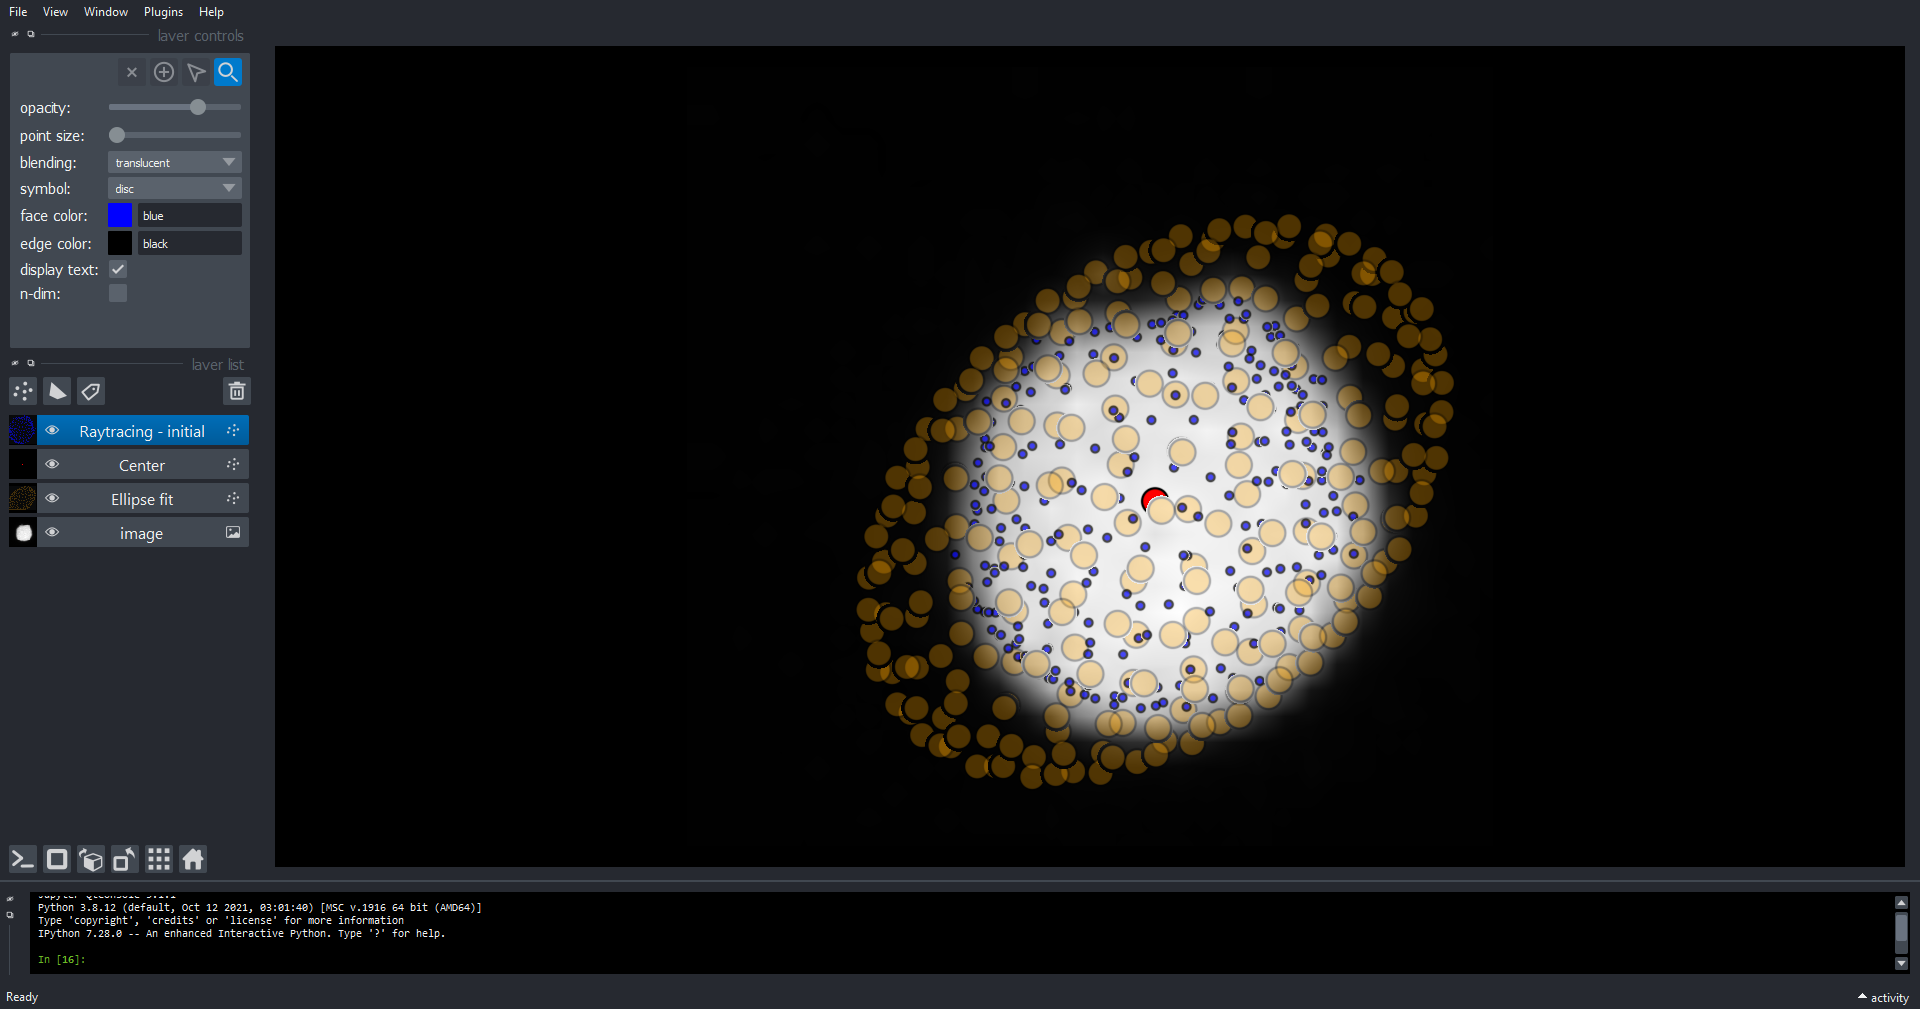

In [17]:
viewer.add_points(utils.df2ZYX(points), size=0.3, face_color ='blue', edge_width=0.1, opacity=0.7, name='Raytracing - initial')
ellipse_layer.opacity=0.3
napari.utils.nbscreenshot(viewer, canvas_only=False)

### Point filtering
The detected points are now filtered regarding neighbourhood, fit errors, etc.